In [17]:
import copy
import os
import sys
from pathlib import Path

import numpy as np
from qutip.solver.floquet import progress_bars
import torch
from pulser import Pulse, Register, Sequence
from pulser.devices import MockDevice
from pulser_diff.backend import TorchEmulator
from pyqtorch.utils import SolverType
from torch import Tensor
import json
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py as h5

In [18]:
sys.path.append("../..")

In [19]:
from source.NAHEA_CNN import NAHEA_CNN_1

In [20]:
# load data from sin dataset
data_save_dir = Path("../../data") / "sin"
data_save_path_train = data_save_dir / "train.h5"
data_save_path_test = data_save_dir / "test.h5"

with h5.File(data_save_path_train, "r") as f:
    X_train = f["X"][:].squeeze(2)
    y_train = f["y"][:]

with h5.File(data_save_path_test, "r") as f:
    X_test = f["X"][:].squeeze(2)
    y_test = f["y"][:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4000, 18)
y_train shape: (4000, 1)
X_test shape: (1000, 18)
y_test shape: (1000, 1)


In [21]:
n_train = 150
n_test = 500 # testing is much faster than training
X_train = X_train[:n_train]
y_train = y_train[:n_train]
X_test = X_test[:n_test]
y_test = y_test[:n_test]

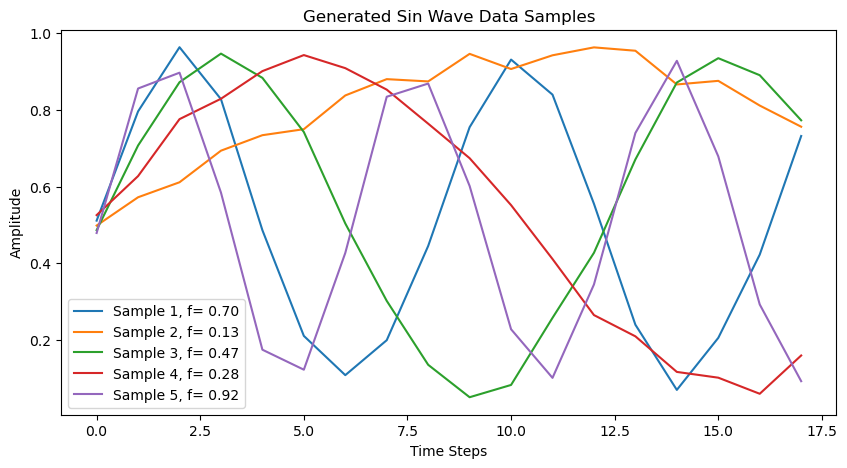

In [22]:
# plot some data
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(X_train[i], label=f"Sample {i+1}, f= {y_train[i][0]:.2f}")
plt.title("Generated Sin Wave Data Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [23]:
seq_len = X_train.shape[1]
hparams = {
    "n_features": (n_features := 4),  # =1D kernel size = number of qubits
    "sampling_rate": 0.2,
    "protocol": "min-delay",
    "n_ancilliary_qubits": (n_ancilliary_qubits := 0), # not implemented
    "input_length": seq_len,
    "stride": 3,  # stride for the convolution
    "output_dim": 1,  # output dimension of the final FC NN
    "hidden_layers_dims": [10, 5],
}

sep = 7.0
parameters = {
    # separation of 7 between the qubits
    "positions": [[sep * i - (sep * 2), 0] for i in range(n_features)],
    "local_pulses_omega_1": [0.5, 1.0, 1.5, 1.0], #, 0.5],
    "local_pulses_delta_1": [0.0] * n_features,
    "global_pulse_omega_1": 1.0,
    "global_pulse_delta_1": 0.0,
    "global_pulse_omega_2": 0.5,
    "global_pulse_delta_2": 0.0,
    "global_pulse_duration": 100,
    "local_pulse_duration": 80,
    "embed_pulse_duration": 80,
}


NAHEA_CNN = NAHEA_CNN_1(
    hparams=hparams, parameters=parameters, name="NAHEA_CNN_3"
)

# set some parameters to not require gradients. They didn't change much last time
NAHEA_CNN._parameters["positions"].requires_grad = False
NAHEA_CNN._parameters["local_pulses_delta_1"].requires_grad = False
NAHEA_CNN._parameters["global_pulse_delta_1"].requires_grad = False
NAHEA_CNN._parameters["global_pulse_delta_2"].requires_grad = False

Final FC NN: Sequential(
  (0): Linear(in_features=5, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)
Adding parameter 0.weight to model
Adding parameter 0.bias to model
Adding parameter 2.weight to model
Adding parameter 2.bias to model
Adding parameter 4.weight to model
Adding parameter 4.bias to model


In [24]:
# train the model
batch_size = 16
epochs = 50
loss_hist = []
# MSE loss function
loss_fn = torch.nn.MSELoss()
NAHEA_CNN.train()
print(f"{NAHEA_CNN.parameters()}")
optimizer = torch.optim.Adam(
    [param for _, param in NAHEA_CNN.parameters().items() if param.requires_grad],
    lr=0.01,
    weight_decay=1e-5,
)
params_hist = [copy.deepcopy(NAHEA_CNN.parameters())]
for epoch in range(epochs):
    # shuffle X_train and y_train
    idxs = np.arange(len(X_train))
    idxs = np.random.permutation(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]

    epoch_losses = []
    for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        x_batch = torch.tensor(X_train[i : i + batch_size], dtype=torch.float64)
        y_batch = torch.tensor(
            y_train[i : i + batch_size], dtype=torch.float64
        ).squeeze(1)
        batch_out = [NAHEA_CNN.forward(xx, dist_grad=False) for xx in x_batch]
        predicted = torch.stack([bo["output"] for bo in batch_out])
        loss = loss_fn(predicted.squeeze(1), y_batch)
        tqdm.write(
            f"Batch {i // batch_size + 1} loss: {loss.item():.4f}, "
            f"RMSE: {np.sqrt(loss.item()):.4f}"
        )
        epoch_losses.append(loss.item())
        loss_hist.append(loss.item())
        loss.backward()
        optimizer.step()
        params_hist.append(copy.deepcopy(NAHEA_CNN.parameters()))
    epoch_loss = np.mean(epoch_losses)
    tqdm.write(f"Epoch {epoch+1} train loss: {epoch_loss}")
loss_hist = np.array(loss_hist)
print(f"Final loss: {loss_hist[-1]}")
print(f"Final loss (RMSE): {np.sqrt(loss_hist[-1])}")

{'positions': tensor([[-14.,   0.],
        [ -7.,   0.],
        [  0.,   0.],
        [  7.,   0.]]), 'local_pulses_omega_1': tensor([0.5000, 1.0000, 1.5000, 1.0000], requires_grad=True), 'local_pulses_delta_1': tensor([0., 0., 0., 0.]), 'global_pulse_omega_1': tensor(1., requires_grad=True), 'global_pulse_delta_1': tensor(0.), 'global_pulse_omega_2': tensor(0.5000, requires_grad=True), 'global_pulse_delta_2': tensor(0.), 'global_pulse_duration': tensor(100.), 'local_pulse_duration': tensor(80.), 'embed_pulse_duration': tensor(80.), 'conv_params': tensor([0.0482, 0.0172, 0.0548, 0.0452, 0.1208, 0.1063, 0.0943, 0.0129, 0.0572,
        0.0521, 0.0889, 0.0489, 0.0272, 0.0529, 0.0580, 0.0384],
       dtype=torch.float64, requires_grad=True), '0.weight': Parameter containing:
tensor([[-0.2455,  0.2205,  0.3501,  0.0470,  0.0323],
        [ 0.3608,  0.2565, -0.1918, -0.3327,  0.1739],
        [-0.4238,  0.1082,  0.3360,  0.0874,  0.3990],
        [-0.3711, -0.1569, -0.1015, -0.4221, -0.176

Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.2773, RMSE: 0.5266
Batch 2 loss: 0.2412, RMSE: 0.4911
Batch 3 loss: 0.1947, RMSE: 0.4412
Batch 4 loss: 0.1976, RMSE: 0.4445
Batch 5 loss: 0.1174, RMSE: 0.3426
Batch 6 loss: 0.0924, RMSE: 0.3040
Batch 7 loss: 0.1306, RMSE: 0.3614
Batch 8 loss: 0.0932, RMSE: 0.3054
Batch 9 loss: 0.0639, RMSE: 0.2529
Batch 10 loss: 0.0403, RMSE: 0.2008
Epoch 1 train loss: 0.14486810136564418


Epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0958, RMSE: 0.3095
Batch 2 loss: 0.1309, RMSE: 0.3619
Batch 3 loss: 0.0685, RMSE: 0.2617
Batch 4 loss: 0.0510, RMSE: 0.2259
Batch 5 loss: 0.0517, RMSE: 0.2274
Batch 6 loss: 0.0772, RMSE: 0.2779
Batch 7 loss: 0.0659, RMSE: 0.2567
Batch 8 loss: 0.0735, RMSE: 0.2711
Batch 9 loss: 0.0755, RMSE: 0.2748
Batch 10 loss: 0.0471, RMSE: 0.2170
Epoch 2 train loss: 0.07371142587247725


Epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0465, RMSE: 0.2156
Batch 2 loss: 0.0747, RMSE: 0.2732
Batch 3 loss: 0.0674, RMSE: 0.2596
Batch 4 loss: 0.0627, RMSE: 0.2504
Batch 5 loss: 0.0519, RMSE: 0.2277
Batch 6 loss: 0.0848, RMSE: 0.2913
Batch 7 loss: 0.0636, RMSE: 0.2521
Batch 8 loss: 0.0495, RMSE: 0.2224
Batch 9 loss: 0.0298, RMSE: 0.1727
Batch 10 loss: 0.1015, RMSE: 0.3186
Epoch 3 train loss: 0.06323267210519667


Epoch 4:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0825, RMSE: 0.2872
Batch 2 loss: 0.0452, RMSE: 0.2126
Batch 3 loss: 0.0513, RMSE: 0.2265
Batch 4 loss: 0.0434, RMSE: 0.2083
Batch 5 loss: 0.0618, RMSE: 0.2486
Batch 6 loss: 0.0519, RMSE: 0.2278
Batch 7 loss: 0.0734, RMSE: 0.2709
Batch 8 loss: 0.0419, RMSE: 0.2046
Batch 9 loss: 0.0588, RMSE: 0.2424
Batch 10 loss: 0.0876, RMSE: 0.2960
Epoch 4 train loss: 0.05977703630598089


Epoch 5:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0210, RMSE: 0.1451
Batch 2 loss: 0.0449, RMSE: 0.2118
Batch 3 loss: 0.0628, RMSE: 0.2507
Batch 4 loss: 0.0541, RMSE: 0.2325
Batch 5 loss: 0.0480, RMSE: 0.2191
Batch 6 loss: 0.0372, RMSE: 0.1930
Batch 7 loss: 0.0570, RMSE: 0.2388
Batch 8 loss: 0.0599, RMSE: 0.2447
Batch 9 loss: 0.0448, RMSE: 0.2117
Batch 10 loss: 0.0640, RMSE: 0.2530
Epoch 5 train loss: 0.04937801480404047


Epoch 6:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0383, RMSE: 0.1958
Batch 2 loss: 0.0494, RMSE: 0.2223
Batch 3 loss: 0.0356, RMSE: 0.1886
Batch 4 loss: 0.0328, RMSE: 0.1811
Batch 5 loss: 0.0461, RMSE: 0.2147
Batch 6 loss: 0.0426, RMSE: 0.2063
Batch 7 loss: 0.0434, RMSE: 0.2084
Batch 8 loss: 0.0466, RMSE: 0.2160
Batch 9 loss: 0.0431, RMSE: 0.2077
Batch 10 loss: 0.0548, RMSE: 0.2342
Epoch 6 train loss: 0.04328082992887312


Epoch 7:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0300, RMSE: 0.1731
Batch 2 loss: 0.0462, RMSE: 0.2150
Batch 3 loss: 0.0467, RMSE: 0.2161
Batch 4 loss: 0.0353, RMSE: 0.1879
Batch 5 loss: 0.0315, RMSE: 0.1775
Batch 6 loss: 0.0222, RMSE: 0.1488
Batch 7 loss: 0.0378, RMSE: 0.1945
Batch 8 loss: 0.0321, RMSE: 0.1792
Batch 9 loss: 0.0263, RMSE: 0.1623
Batch 10 loss: 0.0145, RMSE: 0.1205
Epoch 7 train loss: 0.032257751657852884


Epoch 8:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0220, RMSE: 0.1484
Batch 2 loss: 0.0242, RMSE: 0.1556
Batch 3 loss: 0.0266, RMSE: 0.1630
Batch 4 loss: 0.0172, RMSE: 0.1312
Batch 5 loss: 0.0269, RMSE: 0.1639
Batch 6 loss: 0.0409, RMSE: 0.2022
Batch 7 loss: 0.0267, RMSE: 0.1635
Batch 8 loss: 0.0217, RMSE: 0.1473
Batch 9 loss: 0.0258, RMSE: 0.1607
Batch 10 loss: 0.0076, RMSE: 0.0873
Epoch 8 train loss: 0.02396373180944407


Epoch 9:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0216, RMSE: 0.1471
Batch 2 loss: 0.0216, RMSE: 0.1471
Batch 3 loss: 0.0155, RMSE: 0.1246
Batch 4 loss: 0.0176, RMSE: 0.1326
Batch 5 loss: 0.0221, RMSE: 0.1486
Batch 6 loss: 0.0091, RMSE: 0.0952
Batch 7 loss: 0.0161, RMSE: 0.1268
Batch 8 loss: 0.0130, RMSE: 0.1140
Batch 9 loss: 0.0117, RMSE: 0.1082
Batch 10 loss: 0.0028, RMSE: 0.0528
Epoch 9 train loss: 0.015107527987574837


Epoch 10:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0140, RMSE: 0.1182
Batch 2 loss: 0.0144, RMSE: 0.1199
Batch 3 loss: 0.0211, RMSE: 0.1452
Batch 4 loss: 0.0066, RMSE: 0.0810
Batch 5 loss: 0.0144, RMSE: 0.1199
Batch 6 loss: 0.0093, RMSE: 0.0967
Batch 7 loss: 0.0104, RMSE: 0.1020
Batch 8 loss: 0.0060, RMSE: 0.0776
Batch 9 loss: 0.0058, RMSE: 0.0761
Batch 10 loss: 0.0011, RMSE: 0.0336
Epoch 10 train loss: 0.010305938877403277


Epoch 11:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0064, RMSE: 0.0798
Batch 2 loss: 0.0033, RMSE: 0.0577
Batch 3 loss: 0.0140, RMSE: 0.1182
Batch 4 loss: 0.0108, RMSE: 0.1037
Batch 5 loss: 0.0150, RMSE: 0.1226
Batch 6 loss: 0.0072, RMSE: 0.0848
Batch 7 loss: 0.0110, RMSE: 0.1047
Batch 8 loss: 0.0072, RMSE: 0.0849
Batch 9 loss: 0.0062, RMSE: 0.0788
Batch 10 loss: 0.0051, RMSE: 0.0717
Epoch 11 train loss: 0.008618712395212629


Epoch 12:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0063, RMSE: 0.0793
Batch 2 loss: 0.0041, RMSE: 0.0638
Batch 3 loss: 0.0018, RMSE: 0.0420
Batch 4 loss: 0.0076, RMSE: 0.0871
Batch 5 loss: 0.0077, RMSE: 0.0876
Batch 6 loss: 0.0040, RMSE: 0.0634
Batch 7 loss: 0.0023, RMSE: 0.0479
Batch 8 loss: 0.0076, RMSE: 0.0873
Batch 9 loss: 0.0060, RMSE: 0.0772
Batch 10 loss: 0.0079, RMSE: 0.0887
Epoch 12 train loss: 0.005517635222507917


Epoch 13:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0067, RMSE: 0.0817
Batch 2 loss: 0.0057, RMSE: 0.0752
Batch 3 loss: 0.0018, RMSE: 0.0419
Batch 4 loss: 0.0007, RMSE: 0.0267
Batch 5 loss: 0.0114, RMSE: 0.1069
Batch 6 loss: 0.0031, RMSE: 0.0556
Batch 7 loss: 0.0035, RMSE: 0.0589
Batch 8 loss: 0.0011, RMSE: 0.0331
Batch 9 loss: 0.0012, RMSE: 0.0350
Batch 10 loss: 0.0065, RMSE: 0.0805
Epoch 13 train loss: 0.004159101073042682


Epoch 14:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0013, RMSE: 0.0365
Batch 2 loss: 0.0034, RMSE: 0.0583
Batch 3 loss: 0.0026, RMSE: 0.0506
Batch 4 loss: 0.0032, RMSE: 0.0569
Batch 5 loss: 0.0039, RMSE: 0.0627
Batch 6 loss: 0.0037, RMSE: 0.0607
Batch 7 loss: 0.0020, RMSE: 0.0448
Batch 8 loss: 0.0055, RMSE: 0.0743
Batch 9 loss: 0.0012, RMSE: 0.0344
Batch 10 loss: 0.0025, RMSE: 0.0500
Epoch 14 train loss: 0.002935037901475656


Epoch 15:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0006, RMSE: 0.0243
Batch 2 loss: 0.0017, RMSE: 0.0414
Batch 3 loss: 0.0035, RMSE: 0.0593
Batch 4 loss: 0.0015, RMSE: 0.0388
Batch 5 loss: 0.0020, RMSE: 0.0452
Batch 6 loss: 0.0018, RMSE: 0.0422
Batch 7 loss: 0.0042, RMSE: 0.0646
Batch 8 loss: 0.0030, RMSE: 0.0545
Batch 9 loss: 0.0038, RMSE: 0.0615
Batch 10 loss: 0.0037, RMSE: 0.0604
Epoch 15 train loss: 0.0025727453079390826


Epoch 16:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0012, RMSE: 0.0341
Batch 2 loss: 0.0022, RMSE: 0.0474
Batch 3 loss: 0.0034, RMSE: 0.0582
Batch 4 loss: 0.0020, RMSE: 0.0446
Batch 5 loss: 0.0035, RMSE: 0.0589
Batch 6 loss: 0.0019, RMSE: 0.0432
Batch 7 loss: 0.0034, RMSE: 0.0587
Batch 8 loss: 0.0034, RMSE: 0.0584
Batch 9 loss: 0.0020, RMSE: 0.0448
Batch 10 loss: 0.0011, RMSE: 0.0336
Epoch 16 train loss: 0.002411421897939403


Epoch 17:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0049, RMSE: 0.0701
Batch 2 loss: 0.0017, RMSE: 0.0413
Batch 3 loss: 0.0028, RMSE: 0.0530
Batch 4 loss: 0.0026, RMSE: 0.0513
Batch 5 loss: 0.0037, RMSE: 0.0609
Batch 6 loss: 0.0026, RMSE: 0.0513
Batch 7 loss: 0.0052, RMSE: 0.0720
Batch 8 loss: 0.0012, RMSE: 0.0344
Batch 9 loss: 0.0016, RMSE: 0.0405
Batch 10 loss: 0.0005, RMSE: 0.0225
Epoch 17 train loss: 0.0026904671163994966


Epoch 18:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0017, RMSE: 0.0413
Batch 2 loss: 0.0028, RMSE: 0.0532
Batch 3 loss: 0.0052, RMSE: 0.0722
Batch 4 loss: 0.0025, RMSE: 0.0500
Batch 5 loss: 0.0008, RMSE: 0.0281
Batch 6 loss: 0.0038, RMSE: 0.0617
Batch 7 loss: 0.0046, RMSE: 0.0679
Batch 8 loss: 0.0021, RMSE: 0.0463
Batch 9 loss: 0.0011, RMSE: 0.0337
Batch 10 loss: 0.0041, RMSE: 0.0638
Epoch 18 train loss: 0.0028807223361883424


Epoch 19:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0036, RMSE: 0.0599
Batch 2 loss: 0.0016, RMSE: 0.0396
Batch 3 loss: 0.0017, RMSE: 0.0417
Batch 4 loss: 0.0011, RMSE: 0.0332
Batch 5 loss: 0.0013, RMSE: 0.0355
Batch 6 loss: 0.0014, RMSE: 0.0378
Batch 7 loss: 0.0023, RMSE: 0.0482
Batch 8 loss: 0.0010, RMSE: 0.0321
Batch 9 loss: 0.0006, RMSE: 0.0250
Batch 10 loss: 0.0007, RMSE: 0.0265
Epoch 19 train loss: 0.001535504494240704


Epoch 20:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0009, RMSE: 0.0292
Batch 2 loss: 0.0009, RMSE: 0.0300
Batch 3 loss: 0.0013, RMSE: 0.0362
Batch 4 loss: 0.0007, RMSE: 0.0263
Batch 5 loss: 0.0020, RMSE: 0.0446
Batch 6 loss: 0.0017, RMSE: 0.0410
Batch 7 loss: 0.0025, RMSE: 0.0498
Batch 8 loss: 0.0005, RMSE: 0.0233
Batch 9 loss: 0.0013, RMSE: 0.0366
Batch 10 loss: 0.0022, RMSE: 0.0471
Epoch 20 train loss: 0.0013997164606701113


Epoch 21:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0018, RMSE: 0.0424
Batch 2 loss: 0.0018, RMSE: 0.0426
Batch 3 loss: 0.0010, RMSE: 0.0320
Batch 4 loss: 0.0012, RMSE: 0.0345
Batch 5 loss: 0.0006, RMSE: 0.0243
Batch 6 loss: 0.0014, RMSE: 0.0376
Batch 7 loss: 0.0006, RMSE: 0.0240
Batch 8 loss: 0.0008, RMSE: 0.0279
Batch 9 loss: 0.0012, RMSE: 0.0346
Batch 10 loss: 0.0024, RMSE: 0.0487
Epoch 21 train loss: 0.0012752646720009526


Epoch 22:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0006, RMSE: 0.0237
Batch 2 loss: 0.0008, RMSE: 0.0285
Batch 3 loss: 0.0013, RMSE: 0.0363
Batch 4 loss: 0.0019, RMSE: 0.0437
Batch 5 loss: 0.0015, RMSE: 0.0381
Batch 6 loss: 0.0009, RMSE: 0.0304
Batch 7 loss: 0.0014, RMSE: 0.0379
Batch 8 loss: 0.0019, RMSE: 0.0439
Batch 9 loss: 0.0019, RMSE: 0.0441
Batch 10 loss: 0.0001, RMSE: 0.0104
Epoch 22 train loss: 0.0012403321407391014


Epoch 23:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0012, RMSE: 0.0343
Batch 2 loss: 0.0015, RMSE: 0.0389
Batch 3 loss: 0.0006, RMSE: 0.0249
Batch 4 loss: 0.0021, RMSE: 0.0461
Batch 5 loss: 0.0009, RMSE: 0.0293
Batch 6 loss: 0.0006, RMSE: 0.0244
Batch 7 loss: 0.0008, RMSE: 0.0276
Batch 8 loss: 0.0008, RMSE: 0.0283
Batch 9 loss: 0.0010, RMSE: 0.0313
Batch 10 loss: 0.0008, RMSE: 0.0275
Epoch 23 train loss: 0.0010187194368543493


Epoch 24:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0008, RMSE: 0.0287
Batch 2 loss: 0.0008, RMSE: 0.0274
Batch 3 loss: 0.0007, RMSE: 0.0267
Batch 4 loss: 0.0006, RMSE: 0.0236
Batch 5 loss: 0.0015, RMSE: 0.0392
Batch 6 loss: 0.0008, RMSE: 0.0280
Batch 7 loss: 0.0008, RMSE: 0.0291
Batch 8 loss: 0.0012, RMSE: 0.0351
Batch 9 loss: 0.0021, RMSE: 0.0459
Batch 10 loss: 0.0002, RMSE: 0.0130
Epoch 24 train loss: 0.0009523582382340407


Epoch 25:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0005, RMSE: 0.0229
Batch 2 loss: 0.0005, RMSE: 0.0228
Batch 3 loss: 0.0010, RMSE: 0.0315
Batch 4 loss: 0.0015, RMSE: 0.0392
Batch 5 loss: 0.0012, RMSE: 0.0350
Batch 6 loss: 0.0010, RMSE: 0.0310
Batch 7 loss: 0.0011, RMSE: 0.0330
Batch 8 loss: 0.0007, RMSE: 0.0270
Batch 9 loss: 0.0010, RMSE: 0.0316
Batch 10 loss: 0.0009, RMSE: 0.0302
Epoch 25 train loss: 0.0009489887993120241


Epoch 26:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0008, RMSE: 0.0276
Batch 2 loss: 0.0008, RMSE: 0.0289
Batch 3 loss: 0.0013, RMSE: 0.0359
Batch 4 loss: 0.0011, RMSE: 0.0330
Batch 5 loss: 0.0011, RMSE: 0.0328
Batch 6 loss: 0.0012, RMSE: 0.0342
Batch 7 loss: 0.0006, RMSE: 0.0237
Batch 8 loss: 0.0010, RMSE: 0.0313
Batch 9 loss: 0.0010, RMSE: 0.0310
Batch 10 loss: 0.0006, RMSE: 0.0242
Epoch 26 train loss: 0.0009315475955665507


Epoch 27:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0009, RMSE: 0.0308
Batch 2 loss: 0.0006, RMSE: 0.0254
Batch 3 loss: 0.0006, RMSE: 0.0250
Batch 4 loss: 0.0006, RMSE: 0.0253
Batch 5 loss: 0.0008, RMSE: 0.0277
Batch 6 loss: 0.0015, RMSE: 0.0384
Batch 7 loss: 0.0009, RMSE: 0.0292
Batch 8 loss: 0.0009, RMSE: 0.0295
Batch 9 loss: 0.0011, RMSE: 0.0330
Batch 10 loss: 0.0005, RMSE: 0.0226
Epoch 27 train loss: 0.0008414920732740217


Epoch 28:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0012, RMSE: 0.0351
Batch 2 loss: 0.0009, RMSE: 0.0299
Batch 3 loss: 0.0012, RMSE: 0.0349
Batch 4 loss: 0.0007, RMSE: 0.0274
Batch 5 loss: 0.0012, RMSE: 0.0346
Batch 6 loss: 0.0016, RMSE: 0.0400
Batch 7 loss: 0.0011, RMSE: 0.0337
Batch 8 loss: 0.0008, RMSE: 0.0291
Batch 9 loss: 0.0015, RMSE: 0.0390
Batch 10 loss: 0.0013, RMSE: 0.0356
Epoch 28 train loss: 0.0011661317434354947


Epoch 29:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0011, RMSE: 0.0326
Batch 2 loss: 0.0015, RMSE: 0.0383
Batch 3 loss: 0.0010, RMSE: 0.0320
Batch 4 loss: 0.0012, RMSE: 0.0342
Batch 5 loss: 0.0008, RMSE: 0.0278
Batch 6 loss: 0.0009, RMSE: 0.0294
Batch 7 loss: 0.0008, RMSE: 0.0281
Batch 8 loss: 0.0007, RMSE: 0.0266
Batch 9 loss: 0.0009, RMSE: 0.0299
Batch 10 loss: 0.0012, RMSE: 0.0351
Epoch 29 train loss: 0.0009979939928725806


Epoch 30:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0007, RMSE: 0.0265
Batch 2 loss: 0.0004, RMSE: 0.0201
Batch 3 loss: 0.0010, RMSE: 0.0320
Batch 4 loss: 0.0010, RMSE: 0.0321
Batch 5 loss: 0.0008, RMSE: 0.0274
Batch 6 loss: 0.0005, RMSE: 0.0234
Batch 7 loss: 0.0009, RMSE: 0.0305
Batch 8 loss: 0.0011, RMSE: 0.0332
Batch 9 loss: 0.0011, RMSE: 0.0334
Batch 10 loss: 0.0007, RMSE: 0.0271
Epoch 30 train loss: 0.0008339790821061757


Epoch 31:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0006, RMSE: 0.0235
Batch 2 loss: 0.0014, RMSE: 0.0368
Batch 3 loss: 0.0009, RMSE: 0.0293
Batch 4 loss: 0.0007, RMSE: 0.0259
Batch 5 loss: 0.0010, RMSE: 0.0309
Batch 6 loss: 0.0007, RMSE: 0.0262
Batch 7 loss: 0.0009, RMSE: 0.0301
Batch 8 loss: 0.0013, RMSE: 0.0356
Batch 9 loss: 0.0005, RMSE: 0.0217
Batch 10 loss: 0.0007, RMSE: 0.0272
Epoch 31 train loss: 0.000845876114941157


Epoch 32:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0008, RMSE: 0.0275
Batch 2 loss: 0.0004, RMSE: 0.0209
Batch 3 loss: 0.0006, RMSE: 0.0248
Batch 4 loss: 0.0007, RMSE: 0.0260
Batch 5 loss: 0.0006, RMSE: 0.0237
Batch 6 loss: 0.0010, RMSE: 0.0319
Batch 7 loss: 0.0005, RMSE: 0.0234
Batch 8 loss: 0.0005, RMSE: 0.0223
Batch 9 loss: 0.0006, RMSE: 0.0236
Batch 10 loss: 0.0019, RMSE: 0.0432
Epoch 32 train loss: 0.0007534752110580973


Epoch 33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0005, RMSE: 0.0230
Batch 2 loss: 0.0007, RMSE: 0.0259
Batch 3 loss: 0.0004, RMSE: 0.0195
Batch 4 loss: 0.0010, RMSE: 0.0315
Batch 5 loss: 0.0007, RMSE: 0.0268
Batch 6 loss: 0.0004, RMSE: 0.0206
Batch 7 loss: 0.0006, RMSE: 0.0246
Batch 8 loss: 0.0006, RMSE: 0.0240
Batch 9 loss: 0.0006, RMSE: 0.0244
Batch 10 loss: 0.0003, RMSE: 0.0182
Epoch 33 train loss: 0.0005819418085012731


Epoch 34:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0005, RMSE: 0.0224
Batch 2 loss: 0.0006, RMSE: 0.0240
Batch 3 loss: 0.0006, RMSE: 0.0239
Batch 4 loss: 0.0005, RMSE: 0.0228
Batch 5 loss: 0.0004, RMSE: 0.0207
Batch 6 loss: 0.0005, RMSE: 0.0229
Batch 7 loss: 0.0005, RMSE: 0.0214
Batch 8 loss: 0.0007, RMSE: 0.0266
Batch 9 loss: 0.0011, RMSE: 0.0327
Batch 10 loss: 0.0002, RMSE: 0.0133
Epoch 34 train loss: 0.0005538802965685721


Epoch 35:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0004, RMSE: 0.0197
Batch 2 loss: 0.0006, RMSE: 0.0238
Batch 3 loss: 0.0004, RMSE: 0.0204
Batch 4 loss: 0.0003, RMSE: 0.0185
Batch 5 loss: 0.0008, RMSE: 0.0279
Batch 6 loss: 0.0005, RMSE: 0.0225
Batch 7 loss: 0.0006, RMSE: 0.0255
Batch 8 loss: 0.0004, RMSE: 0.0192
Batch 9 loss: 0.0008, RMSE: 0.0289
Batch 10 loss: 0.0022, RMSE: 0.0467
Epoch 35 train loss: 0.0007026008365163614


Epoch 36:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0007, RMSE: 0.0255
Batch 2 loss: 0.0015, RMSE: 0.0391
Batch 3 loss: 0.0016, RMSE: 0.0401
Batch 4 loss: 0.0012, RMSE: 0.0354
Batch 5 loss: 0.0006, RMSE: 0.0254
Batch 6 loss: 0.0008, RMSE: 0.0278
Batch 7 loss: 0.0013, RMSE: 0.0362
Batch 8 loss: 0.0005, RMSE: 0.0231
Batch 9 loss: 0.0005, RMSE: 0.0233
Batch 10 loss: 0.0007, RMSE: 0.0264
Epoch 36 train loss: 0.0009539633002373302


Epoch 37:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0012, RMSE: 0.0339
Batch 2 loss: 0.0006, RMSE: 0.0243
Batch 3 loss: 0.0008, RMSE: 0.0278
Batch 4 loss: 0.0005, RMSE: 0.0214
Batch 5 loss: 0.0007, RMSE: 0.0256
Batch 6 loss: 0.0006, RMSE: 0.0251
Batch 7 loss: 0.0004, RMSE: 0.0211
Batch 8 loss: 0.0003, RMSE: 0.0176
Batch 9 loss: 0.0003, RMSE: 0.0175
Batch 10 loss: 0.0007, RMSE: 0.0263
Epoch 37 train loss: 0.0006011514905854228


Epoch 38:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0005, RMSE: 0.0233
Batch 2 loss: 0.0005, RMSE: 0.0226
Batch 3 loss: 0.0004, RMSE: 0.0211
Batch 4 loss: 0.0004, RMSE: 0.0200
Batch 5 loss: 0.0005, RMSE: 0.0231
Batch 6 loss: 0.0005, RMSE: 0.0213
Batch 7 loss: 0.0005, RMSE: 0.0227
Batch 8 loss: 0.0005, RMSE: 0.0223
Batch 9 loss: 0.0011, RMSE: 0.0334
Batch 10 loss: 0.0001, RMSE: 0.0110
Epoch 38 train loss: 0.0005140652059952392


Epoch 39:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0006, RMSE: 0.0235
Batch 2 loss: 0.0011, RMSE: 0.0337
Batch 3 loss: 0.0003, RMSE: 0.0160
Batch 4 loss: 0.0003, RMSE: 0.0169
Batch 5 loss: 0.0008, RMSE: 0.0287
Batch 6 loss: 0.0004, RMSE: 0.0192
Batch 7 loss: 0.0005, RMSE: 0.0234
Batch 8 loss: 0.0005, RMSE: 0.0223
Batch 9 loss: 0.0006, RMSE: 0.0238
Batch 10 loss: 0.0009, RMSE: 0.0304
Epoch 39 train loss: 0.0005959851019703796


Epoch 40:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0003, RMSE: 0.0178
Batch 2 loss: 0.0005, RMSE: 0.0231
Batch 3 loss: 0.0006, RMSE: 0.0242
Batch 4 loss: 0.0006, RMSE: 0.0241
Batch 5 loss: 0.0007, RMSE: 0.0255
Batch 6 loss: 0.0004, RMSE: 0.0207
Batch 7 loss: 0.0004, RMSE: 0.0194
Batch 8 loss: 0.0011, RMSE: 0.0326
Batch 9 loss: 0.0005, RMSE: 0.0224
Batch 10 loss: 0.0000, RMSE: 0.0059
Epoch 40 train loss: 0.0005073760490423398


Epoch 41:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0003, RMSE: 0.0176
Batch 2 loss: 0.0007, RMSE: 0.0260
Batch 3 loss: 0.0005, RMSE: 0.0232
Batch 4 loss: 0.0006, RMSE: 0.0250
Batch 5 loss: 0.0005, RMSE: 0.0219
Batch 6 loss: 0.0003, RMSE: 0.0170
Batch 7 loss: 0.0007, RMSE: 0.0262
Batch 8 loss: 0.0008, RMSE: 0.0286
Batch 9 loss: 0.0003, RMSE: 0.0160
Batch 10 loss: 0.0002, RMSE: 0.0155
Epoch 41 train loss: 0.0004921027762587502


Epoch 42:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0009, RMSE: 0.0302
Batch 2 loss: 0.0004, RMSE: 0.0204
Batch 3 loss: 0.0004, RMSE: 0.0197
Batch 4 loss: 0.0003, RMSE: 0.0171
Batch 5 loss: 0.0003, RMSE: 0.0175
Batch 6 loss: 0.0009, RMSE: 0.0299
Batch 7 loss: 0.0003, RMSE: 0.0169
Batch 8 loss: 0.0006, RMSE: 0.0239
Batch 9 loss: 0.0005, RMSE: 0.0213
Batch 10 loss: 0.0005, RMSE: 0.0228
Epoch 42 train loss: 0.0005042675773778756


Epoch 43:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0002, RMSE: 0.0141
Batch 2 loss: 0.0008, RMSE: 0.0275
Batch 3 loss: 0.0007, RMSE: 0.0270
Batch 4 loss: 0.0004, RMSE: 0.0203
Batch 5 loss: 0.0003, RMSE: 0.0169
Batch 6 loss: 0.0007, RMSE: 0.0259
Batch 7 loss: 0.0006, RMSE: 0.0255
Batch 8 loss: 0.0008, RMSE: 0.0281
Batch 9 loss: 0.0004, RMSE: 0.0190
Batch 10 loss: 0.0004, RMSE: 0.0207
Epoch 43 train loss: 0.0005279513674621797


Epoch 44:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0005, RMSE: 0.0216
Batch 2 loss: 0.0007, RMSE: 0.0256
Batch 3 loss: 0.0003, RMSE: 0.0177
Batch 4 loss: 0.0005, RMSE: 0.0216
Batch 5 loss: 0.0006, RMSE: 0.0245
Batch 6 loss: 0.0004, RMSE: 0.0206
Batch 7 loss: 0.0004, RMSE: 0.0193
Batch 8 loss: 0.0004, RMSE: 0.0191
Batch 9 loss: 0.0006, RMSE: 0.0248
Batch 10 loss: 0.0001, RMSE: 0.0094
Epoch 44 train loss: 0.00043639880045914445


Epoch 45:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0006, RMSE: 0.0235
Batch 2 loss: 0.0009, RMSE: 0.0299
Batch 3 loss: 0.0004, RMSE: 0.0207
Batch 4 loss: 0.0004, RMSE: 0.0211
Batch 5 loss: 0.0004, RMSE: 0.0192
Batch 6 loss: 0.0015, RMSE: 0.0385
Batch 7 loss: 0.0004, RMSE: 0.0205
Batch 8 loss: 0.0003, RMSE: 0.0185
Batch 9 loss: 0.0007, RMSE: 0.0273
Batch 10 loss: 0.0008, RMSE: 0.0276
Epoch 45 train loss: 0.0006437236836920833


Epoch 46:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0005, RMSE: 0.0218
Batch 2 loss: 0.0001, RMSE: 0.0107
Batch 3 loss: 0.0006, RMSE: 0.0237
Batch 4 loss: 0.0004, RMSE: 0.0196
Batch 5 loss: 0.0008, RMSE: 0.0275
Batch 6 loss: 0.0004, RMSE: 0.0198
Batch 7 loss: 0.0008, RMSE: 0.0282
Batch 8 loss: 0.0008, RMSE: 0.0285
Batch 9 loss: 0.0007, RMSE: 0.0271
Batch 10 loss: 0.0005, RMSE: 0.0227
Epoch 46 train loss: 0.0005541289571363144


Epoch 47:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0005, RMSE: 0.0228
Batch 2 loss: 0.0005, RMSE: 0.0223
Batch 3 loss: 0.0004, RMSE: 0.0198
Batch 4 loss: 0.0003, RMSE: 0.0180
Batch 5 loss: 0.0008, RMSE: 0.0276
Batch 6 loss: 0.0006, RMSE: 0.0237
Batch 7 loss: 0.0003, RMSE: 0.0184
Batch 8 loss: 0.0005, RMSE: 0.0224
Batch 9 loss: 0.0005, RMSE: 0.0213
Batch 10 loss: 0.0002, RMSE: 0.0152
Epoch 47 train loss: 0.0004585590752301371


Epoch 48:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0005, RMSE: 0.0220
Batch 2 loss: 0.0004, RMSE: 0.0188
Batch 3 loss: 0.0006, RMSE: 0.0237
Batch 4 loss: 0.0008, RMSE: 0.0276
Batch 5 loss: 0.0002, RMSE: 0.0158
Batch 6 loss: 0.0007, RMSE: 0.0262
Batch 7 loss: 0.0006, RMSE: 0.0238
Batch 8 loss: 0.0003, RMSE: 0.0170
Batch 9 loss: 0.0003, RMSE: 0.0186
Batch 10 loss: 0.0024, RMSE: 0.0494
Epoch 48 train loss: 0.0006742995371353177


Epoch 49:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0006, RMSE: 0.0238
Batch 2 loss: 0.0005, RMSE: 0.0218
Batch 3 loss: 0.0007, RMSE: 0.0263
Batch 4 loss: 0.0010, RMSE: 0.0310
Batch 5 loss: 0.0004, RMSE: 0.0208
Batch 6 loss: 0.0006, RMSE: 0.0248
Batch 7 loss: 0.0004, RMSE: 0.0210
Batch 8 loss: 0.0006, RMSE: 0.0241
Batch 9 loss: 0.0007, RMSE: 0.0270
Batch 10 loss: 0.0004, RMSE: 0.0202
Epoch 49 train loss: 0.0005899934819483199


Epoch 50:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0007, RMSE: 0.0271
Batch 2 loss: 0.0004, RMSE: 0.0197
Batch 3 loss: 0.0007, RMSE: 0.0269
Batch 4 loss: 0.0005, RMSE: 0.0216
Batch 5 loss: 0.0004, RMSE: 0.0195
Batch 6 loss: 0.0005, RMSE: 0.0227
Batch 7 loss: 0.0005, RMSE: 0.0223
Batch 8 loss: 0.0007, RMSE: 0.0257
Batch 9 loss: 0.0005, RMSE: 0.0220
Batch 10 loss: 0.0001, RMSE: 0.0109
Epoch 50 train loss: 0.0004959000281467991
Final loss: 0.00011948129143845748
Final loss (RMSE): 0.01093074981135592


In [25]:
# test the model
NAHEA_CNN.eval()
y_pred_test = []
for i in range(len(X_test)):
    x_test = torch.tensor(X_test[i], dtype=torch.float64)
    pred = NAHEA_CNN(x_test)["output"].item()
    y_pred_test.append(pred)
y_pred_test = torch.tensor(y_pred_test, dtype=torch.float64)
y_test = torch.tensor(y_test, dtype=torch.float64).squeeze(1)
loss_test = loss_fn(y_pred_test, y_test)
print(f"Test loss MSE: {loss_test.item()}")
print(f"RMSE: {torch.sqrt(loss_test).item()}")
print("final parameters:")
print(NAHEA_CNN.parameters())

Test loss MSE: 0.0005202782920519675
RMSE: 0.022809609642691554
final parameters:
{'positions': tensor([[-14.,   0.],
        [ -7.,   0.],
        [  0.,   0.],
        [  7.,   0.]]), 'local_pulses_omega_1': tensor([0.5521, 1.2646, 1.6034, 1.4141], requires_grad=True), 'local_pulses_delta_1': tensor([0., 0., 0., 0.]), 'global_pulse_omega_1': tensor(0.9062, requires_grad=True), 'global_pulse_delta_1': tensor(0.), 'global_pulse_omega_2': tensor(0.4521, requires_grad=True), 'global_pulse_delta_2': tensor(0.), 'global_pulse_duration': tensor(100.), 'local_pulse_duration': tensor(80.), 'embed_pulse_duration': tensor(80.), 'conv_params': tensor([ 0.2275,  0.0261, -0.3052,  0.2600,  0.1649, -0.2778,  0.1230,  0.2329,
         0.5720,  0.0564, -0.2216,  0.4880, -0.2829,  0.2790,  0.3478,  0.3214],
       dtype=torch.float64, requires_grad=True), '0.weight': Parameter containing:
tensor([[-1.4289e-01,  5.1043e-01,  4.5887e-01,  2.7165e-01,  6.7847e-02],
        [ 4.6268e-01,  5.4813e-01, -7.4

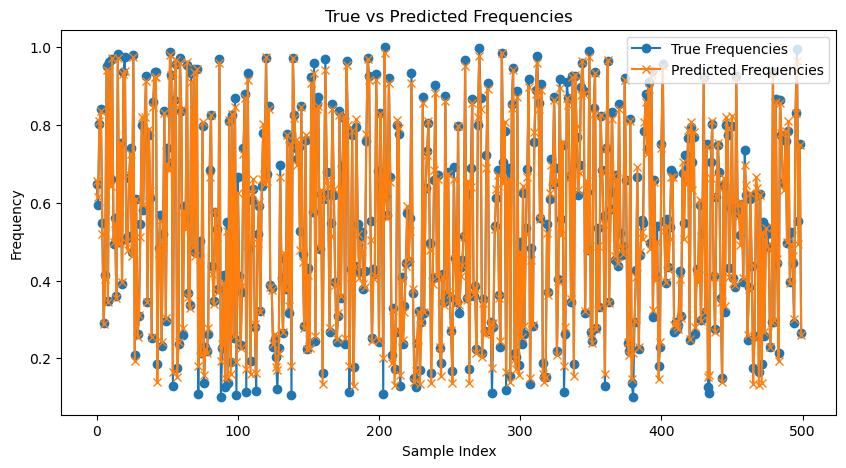

In [26]:
# plot the results
plt.figure(figsize=(10, 5))
plt.plot(y_test.numpy(), label="True Frequencies", marker='o')
plt.plot(y_pred_test.numpy(), label="Predicted Frequencies", marker='x')
plt.title("True vs Predicted Frequencies")
plt.xlabel("Sample Index")
plt.ylabel("Frequency")
plt.legend()
plt.show()

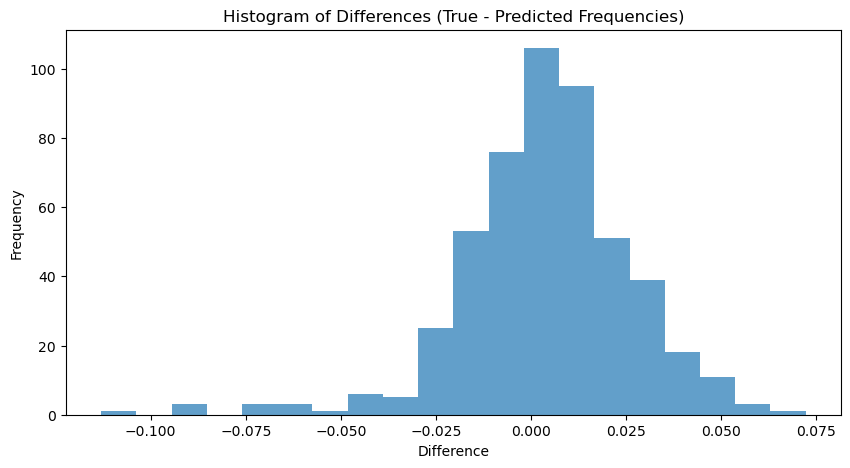

In [27]:
diffs = y_test - y_pred_test
# histogram of the differences
plt.figure(figsize=(10, 5))
plt.hist(diffs.numpy(), bins=20, alpha=0.7)
plt.title("Histogram of Differences (True - Predicted Frequencies)")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.show() 

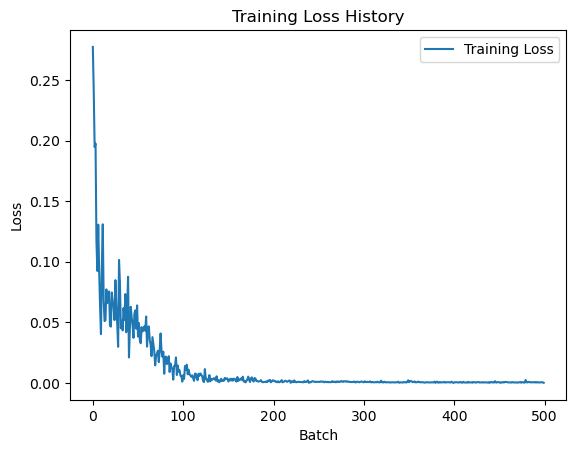

In [28]:
plt.plot(loss_hist, label="Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.show()


In [29]:
params_hist_nice = {
    key: np.array([i[key].detach().numpy() for i in params_hist])
    for key in params_hist[0].keys()
}
print(params_hist_nice.keys())

dict_keys(['positions', 'local_pulses_omega_1', 'local_pulses_delta_1', 'global_pulse_omega_1', 'global_pulse_delta_1', 'global_pulse_omega_2', 'global_pulse_delta_2', 'global_pulse_duration', 'local_pulse_duration', 'embed_pulse_duration', 'conv_params', '0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias'])


In [30]:
positions_hist = np.array([i["positions"].detach().numpy() for i in params_hist])
local_pulses_omega_1_hist = np.array([i["local_pulses_omega_1"].detach().numpy() for i in params_hist])
local_pulses_delta_1_hist = np.array([i["local_pulses_delta_1"].detach().numpy() for i in params_hist])

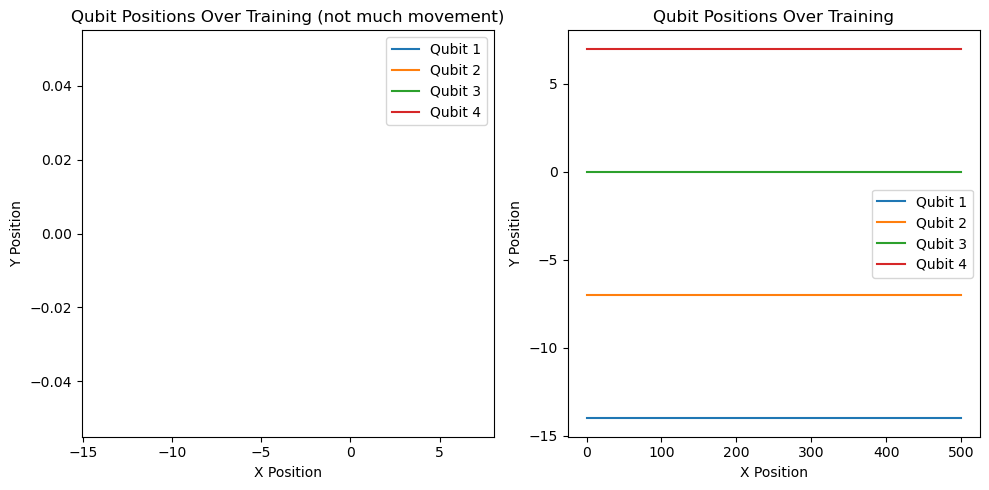

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
for qubit in range(positions_hist.shape[1]):
    plt.plot(positions_hist[:, qubit, 0], positions_hist[:, qubit, 1], label=f"Qubit {qubit+1}")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Qubit Positions Over Training (not much movement)")
plt.legend()
plt.sca(axs[1])
# only first qubit
plt.plot(positions_hist[:, 0, 0], label="Qubit 1")
plt.plot(positions_hist[:, 1, 0], label="Qubit 2")
plt.plot(positions_hist[:, 2, 0], label="Qubit 3")
plt.plot(positions_hist[:, 3, 0], label="Qubit 4")
# plt.plot(positions_hist[:, 4, 0], label="Qubit 5")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Qubit Positions Over Training")
plt.legend()
plt.tight_layout()  
plt.show()  

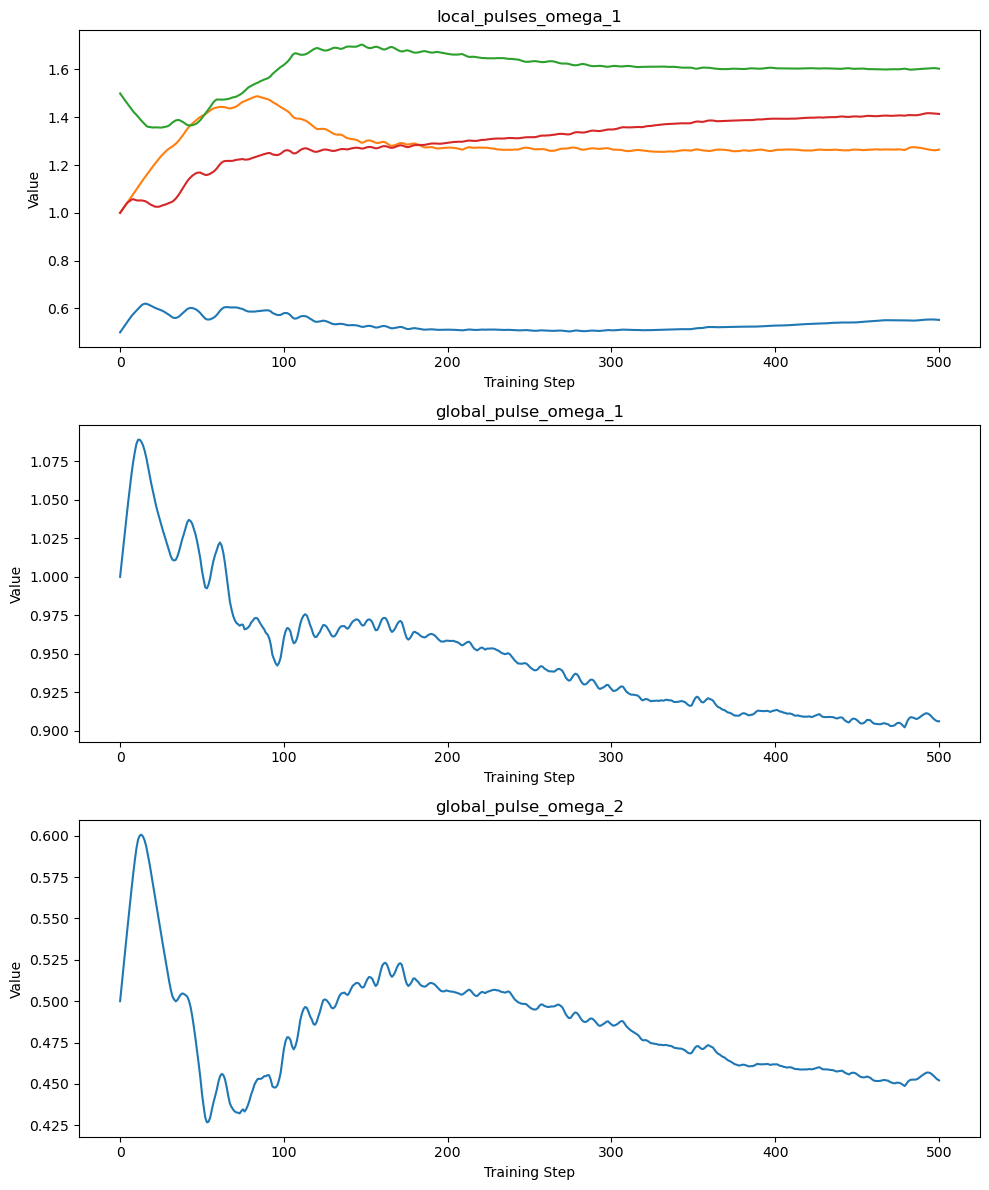

In [34]:
plot_keys = ['local_pulses_omega_1', 'global_pulse_omega_1', 'global_pulse_omega_2']
fig, axs = plt.subplots(len(plot_keys), 1, figsize=(10, 4 * len(plot_keys)))
for i, key in enumerate(plot_keys):
    axs[i].plot(params_hist_nice[key])
    axs[i].set_title(key)
    axs[i].set_xlabel("Training Step")
    axs[i].set_ylabel("Value")
plt.tight_layout()
plt.show()  

In [33]:
import pickle

# number of learned parameters, i.e. with require_grad=True
NAHEA_CNN.train()
# number of parameters
n_params = sum(v.numel() for p, v in NAHEA_CNN.parameters().items() if v.requires_grad)
print(f"Number of trainable parameters: {n_params}")
# save training history
os.makedirs("losses_hist", exist_ok=True)
with open("losses_hist/NAHEA_CNN_dist_grad_false_train_hist.pickle", "wb") as f:
    pickle.dump(
        {
            "loss_hist": loss_hist,
            "params_hist": params_hist,
            "hparams": hparams,
            loss_test.item(): "test_loss",
            "n_learned_parameters": n_params,
        },
        f,
    )

Number of trainable parameters: 143
